# <CENTER> Classification model building for Toy&Games Data

# <CENTER> Import Libraries

In [1]:
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report,accuracy_score, confusion_matrix, f1_score
from sklearn.naive_bayes import MultinomialNB
tfidf = TfidfVectorizer(max_df=0.99,min_df=0.01,stop_words="english",lowercase=True)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline
from prettytable import PrettyTable

import warnings
warnings.filterwarnings("ignore")

# <CENTER> Reading Data 

In [2]:
TG_file = pd.read_csv(r"E:\NIIT\Project\VS_file\T&G_Data.csv")
VG_file = pd.read_csv(r"E:\NIIT\Project\VS_file\VG_Data.csv")

In [3]:
TG_data= TG_file[['text','sentiment']]

In [69]:
TG_data.head(2)

,text,sentiment
0,like item pricing granddaughter wanted mark wa...,Neutral
1,love magnet easel great moving different area ...,Positive


In [70]:
TG_data['sentiment'].value_counts()

Positive    154821
Negative     11689
Neutral       1087
Name: sentiment, dtype: int64

In [71]:
TG_data['num_characters']=TG_data['text'].apply(len)

In [72]:
TG_data.head(2)

,text,sentiment,num_characters
0,like item pricing granddaughter wanted mark wa...,Neutral,72
1,love magnet easel great moving different area ...,Positive,121


In [73]:
sentiment_0_stats = TG_data[TG_data['sentiment'] == 'Positive']['num_characters'].describe()
sentiment_1_stats = TG_data[TG_data['sentiment'] == 'Negative'][ 'num_characters'].describe()
sentiment_2_stats = TG_data[TG_data['sentiment'] == 'Neutral'][ 'num_characters'].describe()

# Concatenate the two DataFrames side by side
combined_stats = pd.concat([sentiment_0_stats, sentiment_1_stats,sentiment_2_stats], axis=1, keys=['Positive (0)', 'Negative (1)','Neutral (2)'])

combined_stats

,Positive (0),Negative (1),Neutral (2)
count,154821.000000,11689.000000,1087.000000
mean,326.423405,355.371974,95.148114
std,378.051611,405.571878,56.411416
min,9.000000,12.000000,4.000000
25%,115.000000,126.000000,66.000000
50%,201.000000,223.000000,86.000000
75%,392.000000,423.000000,113.000000
max,21271.000000,7064.000000,435.000000


# <CENTER> Visualization

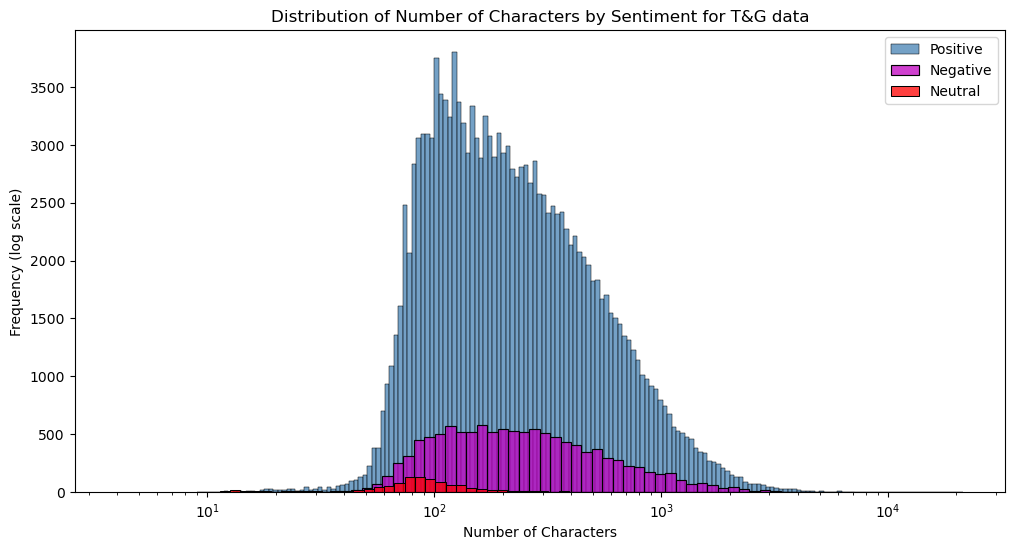

In [74]:
plt.figure(figsize=(12, 6))

sns.histplot(TG_data[TG_data['sentiment'] == 'Positive']['num_characters'], color='steelblue', log_scale=True, label='Positive')
sns.histplot(TG_data[TG_data['sentiment'] == 'Negative']['num_characters'], color='m', log_scale=True, label='Negative')
sns.histplot(TG_data[TG_data['sentiment'] == 'Neutral']['num_characters'], color='red', log_scale=True, label='Neutral')

plt.legend()
plt.xlabel('Number of Characters')
plt.ylabel('Frequency (log scale)')
plt.title('Distribution of Number of Characters by Sentiment for T&G data')
plt.show()

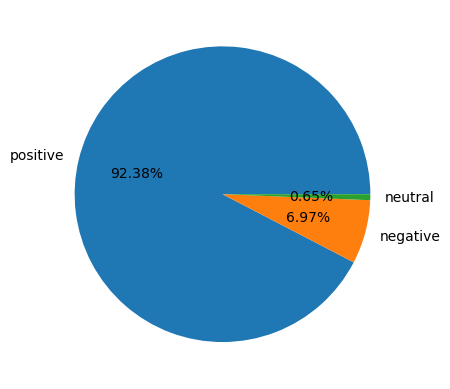

In [75]:
plt.pie(TG_data['sentiment'].value_counts(),labels=['positive','negative','neutral'],autopct="%0.2f%%")
plt.show()

#### Data is imbalanced

# <CENTER> Bi-Variate Analysis

In [76]:
TG_file.head()

,reviewerID,ProductID,reviewerName,overall,Date,text,senti_score,sentiment,title,price,Category,Sub-category,also_buy
0,A1VXOAVRGKGEAK,0439893577,Angie,5.0,2014-01-29,like item pricing granddaughter wanted mark wa...,0.000000,Neutral,Little Red Tool Box: Magnetic Tabletop Learnin...,16.19,Toys & Games,Dress Up & Pretend Play,1
1,A8R62G708TSCM,0439893577,Candace,4.0,2014-03-28,love magnet easel great moving different area ...,0.375000,Positive,Little Red Tool Box: Magnetic Tabletop Learnin...,16.19,Toys & Games,Dress Up & Pretend Play,1
2,A21KH420DK0ICA,0439893577,capemaychristy,5.0,2013-01-28,side magnetic real plus entertaining one child...,0.241071,Positive,Little Red Tool Box: Magnetic Tabletop Learnin...,16.19,Toys & Games,Dress Up & Pretend Play,1
3,AR29QK6HPFYZ4,0439893577,dcrm,5.0,2014-02-08,bought one year ago daughter love still using ...,0.566667,Positive,Little Red Tool Box: Magnetic Tabletop Learnin...,16.19,Toys & Games,Dress Up & Pretend Play,1
4,ACCH8EOML6FN5,0439893577,DoyZ,4.0,2014-05-05,stainless steel refrigerator therefore much sp...,0.500000,Positive,Little Red Tool Box: Magnetic Tabletop Learnin...,16.19,Toys & Games,Dress Up & Pretend Play,1


### Reviewers also bought products

In [110]:
def cat_graph_explode(column1, column2, title, pie=True):
    z = list(np.arange(0, 1, 1 / (len(column1.unique()) - 0.10), dtype=float))
    
    if len(z) <= 5:
        data = column1.value_counts()
        pie, ax = plt.subplots(1, 2, figsize=[20, 6])
        labels = data.keys()
        ax[0].pie(x=data, explode=z, labels=labels, autopct="%0.2f%%")
        sns.countplot(x=column1, hue=column2, ax=ax[1], order=column1.value_counts().index, palette='Set1') 
        
        # Adding count labels to the count plot
        for p in ax[1].patches:
            ax[1].annotate(str(int(p.get_height())), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')

        plt.title(title)
        plt.show()
    else:
        data = column1.value_counts()
        pie, ax = plt.subplots(figsize=[20, 6])
        labels = data.keys()
        sns.countplot(x=column1, hue=column2, ax=ax, order=column1.value_counts().index, palette='Set1')
        
        for p in ax.patches:
            ax.annotate(str(int(p.get_height())), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')

        plt.title(title)
        plt.show()


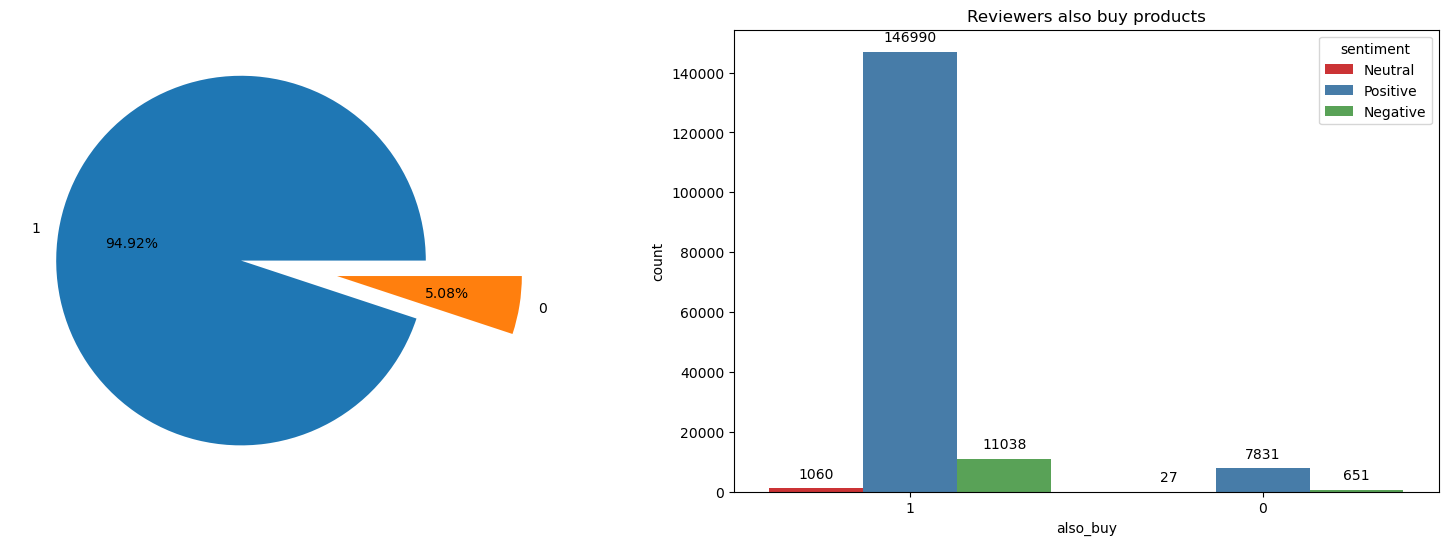

In [111]:
cat_graph_explode(TG_file['also_buy'],TG_file['sentiment'],"Reviewers also buy products")

In [81]:
TG_file.columns

Index(['reviewerID', 'ProductID', 'reviewerName', 'overall', 'Date', 'text',
       'senti_score', 'sentiment', 'title', 'price', 'Category',
       'Sub-category', 'also_buy'],
      dtype='object')

### Top5 Subcategories 

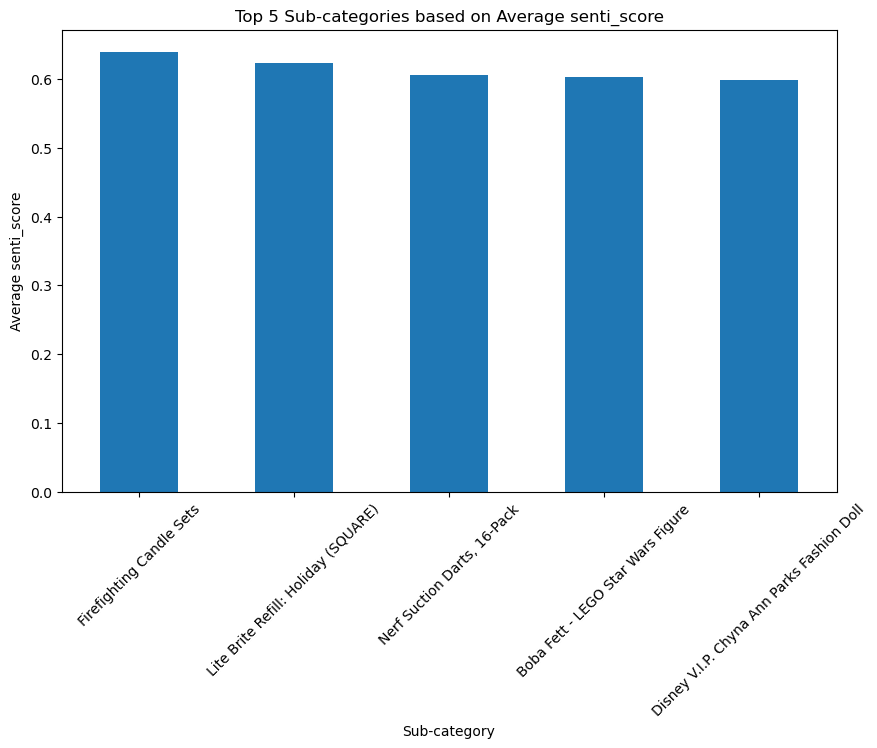

In [99]:
subcat_avg_score = TG_file.groupby('title')['senti_score'].mean()

# Sort the sub-categories based on average senti_score in descending order
sorted_subcats = subcat_avg_score.sort_values(ascending=False)

# Get the top 5 sub-categories
top_5_subcats = sorted_subcats.head(5)

# Plotting
plt.figure(figsize=(10, 6))
top_5_subcats.plot(kind='bar')
plt.title('Top 5 Sub-categories based on Average senti_score')
plt.xlabel('Sub-category')
plt.ylabel('Average senti_score')
plt.xticks(rotation=45)
plt.show()

# <CENTER> Model Building

In [112]:
# Defining X & Y
X = TG_data['text']
Y = TG_data['sentiment']

In [113]:
x_train1, x_test1, y_train1, y_test1 = train_test_split(X,Y, test_size=0.2, random_state=42,stratify=Y)

# Verify the shapes of the split DataFrames
print("TrainX:",x_train1.shape,"Testx:",x_test1.shape,"Trainy:",y_train1.shape,"Testy:",y_test1.shape)

TrainX: (134077,) Testx: (33520,) Trainy: (134077,) Testy: (33520,)


In [114]:
# Vectorize X_train
X_train1 = tfidf.fit_transform(x_train1)
X_test1 = tfidf.transform(x_test1)

## 1. Working with imbalanced Data 

In [115]:
clf = Pipeline([
     ('vectorizer_tfidf',TfidfVectorizer(max_df=0.99,min_df=0.01,stop_words="english",lowercase=True)),    
     ('Multi NB', MultinomialNB())         
])

In [116]:
# Fit the pipeline on the training data
clf.fit(x_train1, y_train1)

# Make predictions on the validation set
y_pred_mb = clf.predict(x_test1)

# Evaluate the model using the modelEvaluation function
def modelEvaluation(predictions):
    print("\nAccuracy on validation set: {:.4f}".format(accuracy_score(y_test1, predictions)))
    print("\nClassification report:\n", classification_report(y_test1, predictions))
    print("\nConfusion Matrix:\n", confusion_matrix(y_test1, predictions))

modelEvaluation(y_pred_mb)


Accuracy on validation set: 0.9242

Classification report:
               precision    recall  f1-score   support

    Negative       0.70      0.01      0.02      2338
     Neutral       0.00      0.00      0.00       217
    Positive       0.92      1.00      0.96     30965

    accuracy                           0.92     33520
   macro avg       0.54      0.34      0.33     33520
weighted avg       0.90      0.92      0.89     33520


Confusion Matrix:
 [[   23     0  2315]
 [    0     0   217]
 [   10     0 30955]]


In [ ]:
clf_lr = Pipeline([
     ('vectorizer_tfidf',TfidfVectorizer(max_df=0.99,min_df=0.01,stop_words="english",lowercase=True)),    
     ('LogisticRegression', LogisticRegression())         
])
clf_lr.fit(x_train1, y_train1)
y_pred_lr = clf_lr.predict(x_test1)
modelEvaluation(y_pred_lr)


Accuracy on validation set: 0.9529

Classification report:
               precision    recall  f1-score   support

    Negative       0.80      0.54      0.64      2338
     Neutral       0.63      0.11      0.19       217
    Positive       0.96      0.99      0.98     30965

    accuracy                           0.95     33520
   macro avg       0.80      0.55      0.60     33520
weighted avg       0.95      0.95      0.95     33520


Confusion Matrix:
 [[ 1252     3  1083]
 [   31    24   162]
 [  289    11 30665]]


In [ ]:
clf_rf = Pipeline([
     ('vectorizer_tfidf',TfidfVectorizer(max_df=0.99,min_df=0.01,stop_words="english",lowercase=True)),    
     ('RandomForest', RandomForestClassifier(n_estimators=100,criterion ='entropy',random_state = 42))         
])
clf_rf.fit(x_train1, y_train1)
y_pred_rf = clf_rf.predict(x_test1)
modelEvaluation(y_pred_rf)


Accuracy on validation set: 0.9339

Classification report:
               precision    recall  f1-score   support

    Negative       0.87      0.15      0.26      2338
     Neutral       0.62      0.25      0.36       217
    Positive       0.94      1.00      0.97     30965

    accuracy                           0.93     33520
   macro avg       0.81      0.47      0.53     33520
weighted avg       0.93      0.93      0.91     33520


Confusion Matrix:
 [[  359    11  1968]
 [    3    55   159]
 [   51    22 30892]]


In [ ]:
rep_lr=classification_report(y_test1, y_pred_lr)

## 1. Working with Data Balancing using Class Weight  

### Formula of Class Weights
wj=n_samples / (n_classes * n_samplesj)

*wj is the weight for each class(j signifies the class)*  
*n_samplesis the total number of samples or rows in the dataset*  
*n_classesis the total number of unique classes in the target*  
*n_samplesjis the total number of rows of the respective class* 

In [ ]:
model_lr_cw = Pipeline([
     ('vectorizer_tfidf',TfidfVectorizer(max_df=0.99,min_df=0.01,stop_words="english",lowercase=True)),    
     ('LogisticRegression', LogisticRegression(multi_class='multinomial',class_weight={'Positive':0.36,'Negative':4.78,'Neutral':51.39}))        
])
model_lr_cw.fit(x_train1, y_train1)
y_pred_lrcw = model_lr_cw.predict(x_test1)
modelEvaluation(y_pred_lrcw)


Accuracy on validation set: 0.8680

Classification report:
               precision    recall  f1-score   support

    Negative       0.40      0.83      0.53      2338
     Neutral       0.12      0.82      0.21       217
    Positive       0.99      0.87      0.93     30965

    accuracy                           0.87     33520
   macro avg       0.50      0.84      0.56     33520
weighted avg       0.95      0.87      0.90     33520


Confusion Matrix:
 [[ 1931   212   195]
 [   35   179     3]
 [ 2919  1062 26984]]


In [ ]:
model_rf_cw = Pipeline([
     ('vectorizer_tfidf',TfidfVectorizer(max_df=0.99,min_df=0.01,stop_words="english",lowercase=True)),    
     ('RandomForestClassifier', RandomForestClassifier(n_estimators=100,criterion ='entropy',random_state = 42,class_weight={'Positive':0.36,'Negative':4.78,'Neutral':51.39}))        
])
model_rf_cw.fit(x_train1, y_train1)
y_pred_rfcw = model_rf_cw.predict(x_test1)
modelEvaluation(y_pred_rfcw)


Accuracy on validation set: 0.9337

Classification report:
               precision    recall  f1-score   support

    Negative       0.85      0.15      0.26      2338
     Neutral       0.59      0.30      0.40       217
    Positive       0.94      1.00      0.97     30965

    accuracy                           0.93     33520
   macro avg       0.79      0.48      0.54     33520
weighted avg       0.93      0.93      0.91     33520


Confusion Matrix:
 [[  355    15  1968]
 [    5    65   147]
 [   58    30 30877]]


In [ ]:
rep_rf_cw=classification_report(y_test1, y_pred_rfcw)

# Using Smote function

In [117]:
sm = SMOTE(random_state=42)
X_train_res1,Y_train_res1=sm.fit_resample(X_train1,y_train1)
print(X_train_res1.shape,Y_train_res1.shape)

(371568, 612) (371568,)


In [ ]:
# Define the data
class_labels = ['Class 0', 'Class 1', 'Class 2']
y_train_counts = [123856, 9351, 870]
Y_train_res_counts = [123856, 123856, 123856]

# Create a PrettyTable object and add data in one step
table = PrettyTable(["Class", "y_train Count", "Y_train_res Count"])
table.add_rows(zip(class_labels, y_train_counts, Y_train_res_counts))
# Print the table
print('After smote: \nX_train:-',X_train_res1.shape,'Y_train:-',Y_train_res1.shape)
print('\n')
print(table)

After smote: 
X_train:- (371568, 612) Y_train:- (371568,)


+---------+---------------+-------------------+
|  Class  | y_train Count | Y_train_res Count |
+---------+---------------+-------------------+
| Class 0 |     123856    |       123856      |
| Class 1 |      9351     |       123856      |
| Class 2 |      870      |       123856      |
+---------+---------------+-------------------+


### Above shows the y_train data balancing using SMOTE 

### NaiveBayes model using Smote

In [ ]:
# Define your SMOTE pipeline
model_lr_mb = make_pipeline(TfidfVectorizer(max_df=0.99, min_df=0.01, stop_words="english", lowercase=True),
                            SMOTE(random_state=42),
                            MultinomialNB())
model_lr_mb.fit(x_train1, y_train1)
y_pred_mbsm = model_lr_mb.predict(x_test1)
modelEvaluation(y_pred_mbsm)


Accuracy on validation set: 0.8145

Classification report:
               precision    recall  f1-score   support

    Negative       0.27      0.70      0.39      2338
     Neutral       0.09      0.65      0.16       217
    Positive       0.98      0.82      0.90     30965

    accuracy                           0.81     33520
   macro avg       0.45      0.72      0.48     33520
weighted avg       0.92      0.81      0.86     33520


Confusion Matrix:
 [[ 1630   191   517]
 [   45   141    31]
 [ 4263  1172 25530]]


### Logistic Regression model using Smote

In [ ]:
# Define your SMOTE pipeline
model_lr_sm = make_pipeline(TfidfVectorizer(max_df=0.99, min_df=0.01,stop_words="english", lowercase=True),
                            SMOTE(random_state=42),
                            LogisticRegression(multi_class='multinomial'))
model_lr_sm.fit(x_train1, y_train1)
y_pred_lrsm = model_lr_sm.predict(x_test1)
modelEvaluation(y_pred_lrsm)


Accuracy on validation set: 0.9017

Classification report:
               precision    recall  f1-score   support

    Negative       0.46      0.80      0.58      2338
     Neutral       0.18      0.76      0.29       217
    Positive       0.99      0.91      0.95     30965

    accuracy                           0.90     33520
   macro avg       0.54      0.82      0.61     33520
weighted avg       0.95      0.90      0.92     33520


Confusion Matrix:
 [[ 1874   145   319]
 [   47   164     6]
 [ 2172   606 28187]]


### Random Forest model using Smote

In [118]:
# Define your SMOTE pipeline
model_rf_sm = make_pipeline(TfidfVectorizer(max_df=0.99, min_df=0.01,stop_words="english", lowercase=True),
                            SMOTE(random_state=42),
                            RandomForestClassifier(n_estimators=100,criterion ='entropy',random_state = 42))
model_rf_sm.fit(x_train1, y_train1)
y_pred_rfsm = model_rf_sm.predict(x_test1)
modelEvaluation(y_pred_rfsm)


Accuracy on validation set: 0.9289

Classification report:
               precision    recall  f1-score   support

    Negative       0.52      0.46      0.49      2338
     Neutral       0.53      0.54      0.54       217
    Positive       0.96      0.97      0.96     30965

    accuracy                           0.93     33520
   macro avg       0.67      0.66      0.66     33520
weighted avg       0.93      0.93      0.93     33520


Confusion Matrix:
 [[ 1072    30  1236]
 [   27   118    72]
 [  944    74 29947]]


In [141]:
print("Random forest model using SMOTE")
# Calculate accuracy
accuracy = accuracy_score(y_test1, y_pred_rfsm)
print(f'Accuracy: {accuracy:.2f}')

# Calculate F1 score
f1 = f1_score(y_test1, y_pred_rfsm, average='weighted')  # 'weighted' takes class imbalance into account
print(f'F1 Score: {f1:.2f}')

Random forest model using SMOTE
Accuracy: 0.93
F1 Score: 0.93


In [ ]:
rep_rf_sm=classification_report(y_test1, y_pred_rfsm)

## Comparing all best models from all techniques

In [ ]:
Report = [rep_lr,rep_rf_cw,rep_rf_sm]
Model_name = ["LR_unbalanced","RF_classweight","RF_smote"]
Model=["M1","M2","M3"]

# Create a PrettyTable object and add data in one step
table = PrettyTable(["MODEL", "Model_name", "Classification_Report"])
table.add_rows(zip(Model, Model_name, Report))
# Print the table
print("\n***Random forest with Smote is given us the best result hence all below comparisons between all 3 best models.***")
print(table)


***Random forest with Smote is given us the best result hence all below comparisons between all 3 best models.***
+-------+----------------+-------------------------------------------------------+
| MODEL |   Model_name   |                 Classification_Report                 |
+-------+----------------+-------------------------------------------------------+
|   M1  | LR_unbalanced  |               precision    recall  f1-score   support |
|       |                |                                                       |
|       |                |     Negative       0.80      0.54      0.64      2338 |
|       |                |      Neutral       0.63      0.11      0.19       217 |
|       |                |     Positive       0.96      0.99      0.98     30965 |
|       |                |                                                       |
|       |                |     accuracy                           0.95     33520 |
|       |                |    macro avg       0.80     

In [ ]:
model_rf_cw

Pipeline(steps=[('vectorizer_tfidf',
                 TfidfVectorizer(max_df=0.99, min_df=0.01,
                                 stop_words='english')),
                ('RandomForestClassifier',
                 RandomForestClassifier(class_weight={'Negative': 4.78,
                                                      'Neutral': 51.39,
                                                      'Positive': 0.36},
                                        criterion='entropy',
                                        random_state=42))])

In [ ]:
model_rf_sm.predict(['This toy is fantastic! My kids can’t get enough of it, and it’s been keeping them entertained for hours. Well worth the purchase.'])

array(['Positive'], dtype=object)

In [ ]:
model_rf_sm.predict(['Awful quality, fell apart within days. Waste of money, wouldn’t recommend'])

array(['Negative'], dtype=object)

In [ ]:
model_rf_sm.predict(["I was disappointed with Board Game. The rules were confusing, and the game dragged on for too long. It didn't live up to the hype for me."])

array(['Negative'], dtype=object)

# <CENTER> PART-2 Classification model building for Video Games Data

In [4]:
VG_file.head(2)

,ProductID,price,Category,Sub-category,also_buy,reviewerID,reviewerName,overall,Date,text,senti_score,sentiment
0,0700099867,246.63,Video Games,PC,1,A2HD75EMZR8QLN,123,1.0,2012-07-09,installing game struggle game window live bug ...,-0.109790,Negative
1,0700099867,246.63,Video Games,PC,1,A3UR8NLLY1ZHCX,"Alejandro Henao ""Electronic Junky""",4.0,2013-06-30,like rally car get game fun oriented european ...,0.154545,Positive


In [5]:
VG_data= VG_file[['text','sentiment']]

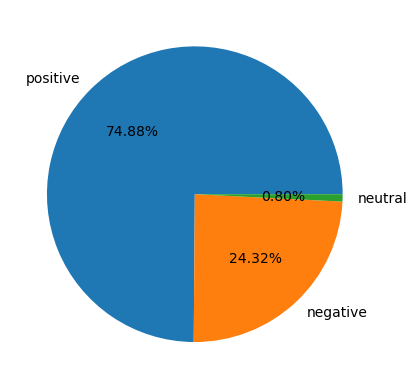

In [6]:
plt.pie(VG_data['sentiment'].value_counts(),labels=['positive','negative','neutral'],autopct="%0.2f%%")
plt.show()

## Data is imbalanced

In [ ]:
VG_data['num_characters']=VG_data['text'].apply(len)

In [ ]:
sentiment_0_stats2 = VG_data[VG_data['sentiment'] == 'Positive']['num_characters'].describe()
sentiment_1_stats2 = VG_data[VG_data['sentiment'] == 'Negative'][ 'num_characters'].describe()
sentiment_2_stats2 = VG_data[VG_data['sentiment'] == 'Neutral'][ 'num_characters'].describe()

# Concatenate the two DataFrames side by side
combined_stats2 = pd.concat([sentiment_0_stats2, sentiment_1_stats2,sentiment_2_stats2], axis=1, keys=['Positive (0)', 'Negative (1)','Neutral (2)'])

combined_stats2

,Positive (0),Negative (1),Neutral (2)
count,173567.000000,56358.000000,1855.000000
mean,709.802716,678.848735,119.930997
std,985.354534,858.826008,155.584039
min,9.000000,11.000000,6.000000
25%,151.000000,180.000000,65.000000
50%,353.000000,389.000000,93.000000
75%,853.000000,827.000000,142.000000
max,20784.000000,18278.000000,3909.000000


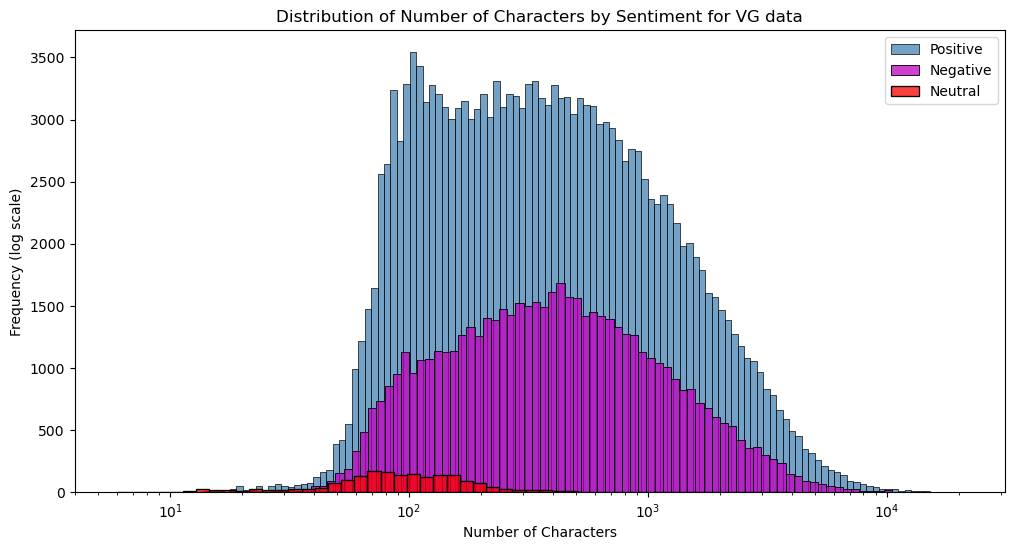

In [ ]:
plt.figure(figsize=(12, 6))

sns.histplot(VG_data[VG_data['sentiment'] == 'Positive']['num_characters'], color='steelblue', log_scale=True, label='Positive')
sns.histplot(VG_data[VG_data['sentiment'] == 'Negative']['num_characters'], color='m', log_scale=True, label='Negative')
sns.histplot(VG_data[VG_data['sentiment'] == 'Neutral']['num_characters'], color='red', log_scale=True, label='Neutral')

plt.legend()
plt.xlabel('Number of Characters')
plt.ylabel('Frequency (log scale)')
plt.title('Distribution of Number of Characters by Sentiment for VG data')
plt.show()

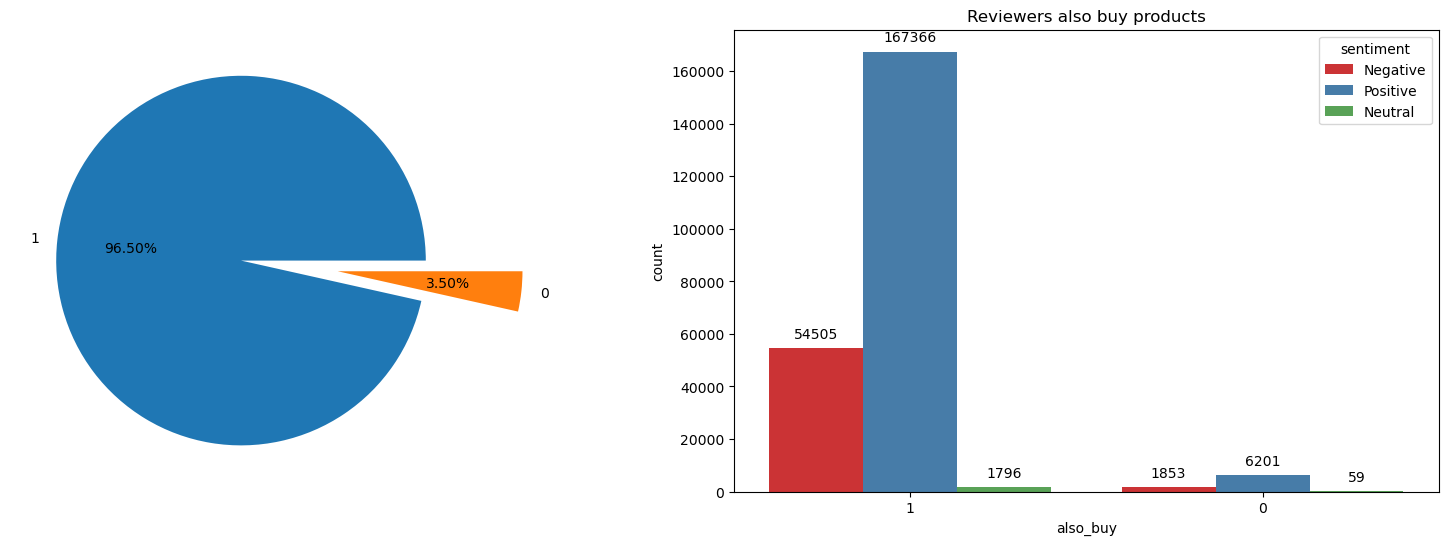

In [102]:
cat_graph_explode(VG_file['also_buy'],VG_file['sentiment'],"Reviewers also buy products")

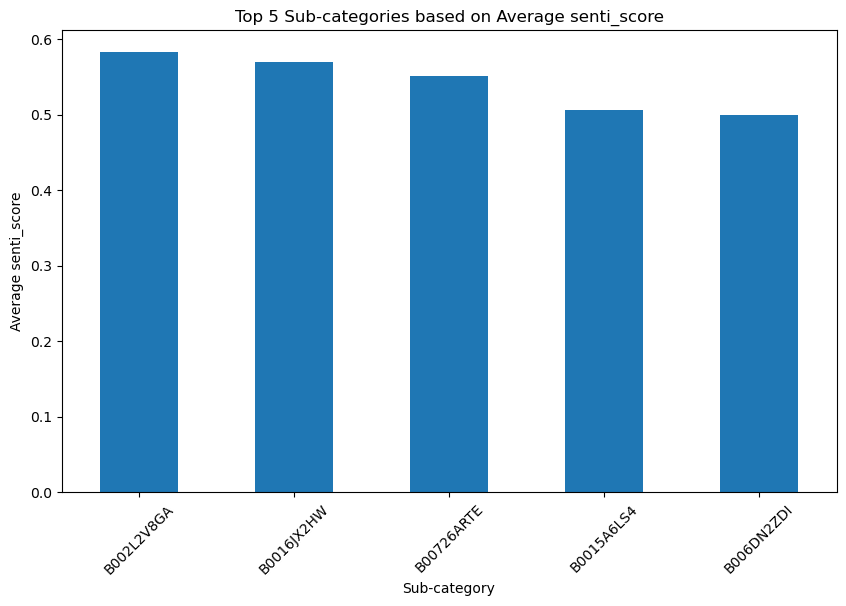

In [95]:
subcat_avg_score = VG_file.groupby('ProductID')['senti_score'].mean()

# Sort the sub-categories based on average senti_score in descending order
sorted_subcats = subcat_avg_score.sort_values(ascending=False)

# Get the top 5 sub-categories
top_5_subcats = sorted_subcats.head(5)

# Plotting
plt.figure(figsize=(10, 6))
top_5_subcats.plot(kind='bar')
plt.title('Top 5 Sub-categories based on Average senti_score')
plt.xlabel('Sub-category')
plt.ylabel('Average senti_score')
plt.xticks(rotation=45)
plt.show()

# <CENTER> Model Building

In [7]:
X2 = VG_data['text']
Y2 = VG_data['sentiment']

In [8]:
print("X2 shape:", X2.shape)
print("Y2 shape:", Y2.shape)

X2 shape: (231780,)
Y2 shape: (231780,)


In [10]:
x_train2, x_test2, y_train2, y_test2 = train_test_split(X2,Y2, test_size=0.2, random_state=42,stratify=Y2)
# Verify the shapes of the split DataFrames
print("TrainX:",x_train2.shape,"Testx:",x_test2.shape,"Trainy:",y_train2.shape,"Testy:",y_test2.shape)

TrainX: (185424,) Testx: (46356,) Trainy: (185424,) Testy: (46356,)


In [11]:
X_train2 = tfidf.fit_transform(x_train2)
X_test2= tfidf.transform(x_test2)

## USING CLASS WEIGHT

In [12]:
model_lr_cw2 = Pipeline([
     ('vectorizer_tfidf',TfidfVectorizer(max_df=0.99,min_df=0.01,stop_words="english",lowercase=True)),    
     ('LogisticRegression', LogisticRegression(multi_class='multinomial',class_weight={'Positive':0.44,'Negative':1.37,'Neutral':41.65}))        
])
model_lr_cw2.fit(x_train2, y_train2)
y_pred_lrcw2 = model_lr_cw2.predict(x_test2)
print(classification_report(y_test2, y_pred_lrcw2))

              precision    recall  f1-score   support

    Negative       0.78      0.89      0.83     11272
     Neutral       0.18      0.91      0.29       371
    Positive       0.98      0.88      0.93     34713

    accuracy                           0.89     46356
   macro avg       0.64      0.90      0.68     46356
weighted avg       0.92      0.89      0.90     46356



In [13]:
model_rf_cw2 = Pipeline([
     ('vectorizer_tfidf',TfidfVectorizer(max_df=0.99,min_df=0.01,stop_words="english",lowercase=True)),    
     ('RandomForestClassifier', RandomForestClassifier(n_estimators=100,criterion ='entropy',random_state = 42,class_weight={'Positive':0.44,'Negative':1.37,'Neutral':41.65}))        
])
model_rf_cw2.fit(x_train2, y_train2)
y_pred_rfcw2 = model_rf_cw2.predict(x_test2)
print(classification_report(y_test2, y_pred_rfcw2))

              precision    recall  f1-score   support

    Negative       0.89      0.43      0.58     11272
     Neutral       0.75      0.60      0.66       371
    Positive       0.84      0.98      0.90     34713

    accuracy                           0.84     46356
   macro avg       0.83      0.67      0.72     46356
weighted avg       0.85      0.84      0.82     46356



## USING SMOTE FUNCTION

In [14]:
sm = SMOTE(random_state=42)
X_train_res2,Y_train_res2=sm.fit_resample(X_train2,y_train2)
print(X_train_res2.shape,Y_train_res2.shape)

(416562, 1231) (416562,)


### NaiveBayes model using Smote

In [15]:
model_mb_sm2=MultinomialNB()
model_mb_sm2.fit(X_train_res2, Y_train_res2)
y_pred_mbsm2 = model_mb_sm2.predict(X_test2)

# Print the classification report
print(classification_report(y_test2, y_pred_mbsm2))

              precision    recall  f1-score   support

    Negative       0.55      0.74      0.63     11272
     Neutral       0.08      0.66      0.14       371
    Positive       0.92      0.74      0.82     34713

    accuracy                           0.74     46356
   macro avg       0.51      0.71      0.53     46356
weighted avg       0.82      0.74      0.77     46356



### Logistic Regression model using Smote

In [16]:
model_lr_sm2=LogisticRegression(multi_class='multinomial')
model_lr_sm2.fit(X_train_res2, Y_train_res2)
y_pred_lrsm2 = model_lr_sm2.predict(X_test2)

# Print the classification report
print(classification_report(y_test2, y_pred_lrsm2))

              precision    recall  f1-score   support

    Negative       0.80      0.89      0.85     11272
     Neutral       0.26      0.84      0.40       371
    Positive       0.97      0.91      0.94     34713

    accuracy                           0.91     46356
   macro avg       0.68      0.88      0.73     46356
weighted avg       0.92      0.91      0.91     46356



### Random Forest model using Smote

In [17]:
model_rf_sm2=RandomForestClassifier(n_estimators=100,criterion ='entropy',random_state = 42)
model_rf_sm2.fit(X_train_res2, Y_train_res2)
y_pred_rfsm2 = model_rf_sm2.predict(X_test2)

# Print the classification report
print(classification_report(y_test2, y_pred_rfsm2))

              precision    recall  f1-score   support

    Negative       0.72      0.63      0.67     11272
     Neutral       0.57      0.66      0.61       371
    Positive       0.88      0.92      0.90     34713

    accuracy                           0.85     46356
   macro avg       0.72      0.74      0.73     46356
weighted avg       0.84      0.85      0.84     46356



In [20]:
print("Logistic regression  model using SMOTE")
# Calculate accuracy
accuracy = accuracy_score(y_test2, y_pred_lrsm2)
print(f'Accuracy: {accuracy:.2f}')

# Calculate F1 score
f1 = f1_score(y_test2, y_pred_lrsm2, average='weighted')  # 'weighted' takes class imbalance into account
print(f'F1 Score: {f1:.2f}')

Logistic regression  model using SMOTE
Accuracy: 0.91
F1 Score: 0.91


## Random Forest model with SMOTE emerged as the optimal choice

## Prediction on VG Data Model

In [29]:
text_to_predict = ["Fantastic game! Great graphics, immersive gameplay, and an engaging storyline make it a must-play for any gamer."]
transformed_text = tfidf.transform(text_to_predict)
model_lr_sm2.predict(transformed_text)

array(['Positive'], dtype=object)

In [28]:
text_to_predict = ["Disappointing. Clunky controls, mediocre graphics, and a shallow storyline make this game not worth the money"]
transformed_text = tfidf.transform(text_to_predict)
model_lr_sm2.predict(transformed_text)

array(['Negative'], dtype=object)

# <CENTER> API 

### Streamlit is a popular Python library for creating web applications, we are using this library to create our API

In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
import string

nltk.download('punkt')
nltk.download('stopwords')

def transform_text(text):
    text = text.lower()
    text = nltk.word_tokenize(text)
    y = []
    for i in text:
        if i.isalnum():
            y.append(i)
    text = y[:]
    y.clear()
    for i in text:
        if i not in stopwords.words('english') and i not in string.punctuation:
            y.append(i)       
    text = y[:]
    y.clear()
    
    ps = PorterStemmer()
    for i in text:
        y.append(ps.stem(i))
            
    return " ".join(y)

    

### Below we are using pickle to dump best models to use in API building.

In [31]:
import pickle
pickle.dump(tfidf,open('vectorizer.pkl','wb'))
pickle.dump(model_rf_sm,open('model_pip.pkl','wb'))
pickle.dump(model_lr_sm2,open('model_pip_VG.pkl','wb'))